# Кластеризация и модель прогнозирования для уменьшения оттока пользователей сети фитнес-центров

### Описание проекта
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных. Для этого нужно проанализировать данные на месяц до оттока и факт оттока на определённый месяц. Индикатором оттока является отсутствие посещений спортзала пользователем за последний месяц.   

**Задача**: провести анализ и подготовить план действий по удержанию клиентов. А именно:  
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:  
    1) выделить целевые группы клиентов;  
    2) предложить меры по снижению оттока;  
    3) определить другие особенности взаимодействия с клиентами.

## Навигация по содержанию
<a name='back'> </a>
- [Библиотеки](#libraries)  
- [1. Знакомство с данными ](#dataintro)  
- [2. Предобработка данных](#datacleaning)       
- [3. Исследовательский анализ данных](#analysis)
- [4. Модель прогнозирования оттока пользователей ](#predictions)
- [5. Кластеризация пользователей](#clusters)
- [Общий вывод](#conclusion)
 



### Библиотеки <a name="libraries"></a>

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
from math import factorial 
from scipy import stats as st 
import numpy as np 
import seaborn as sns; sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, r2_score, silhouette_score

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
import warnings
warnings.filterwarnings('ignore')  

## 1. Знакомство с данными <a name="dataintro"></a>
#### [Вернуться к оглавлению](#back) 

#### Описание данных
В файле gym_churn содержатся данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:
- 'Churn' — факт оттока в текущем месяце;

Текущие поля в датасете:  
Данные пользователя за предыдущий до проверки факта оттока месяц:  
- 'gender' — пол
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- 'Phone' — наличие контактного телефона
- 'Age' — возраст
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)  

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента  
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
- 'Group_visits' — факт посещения групповых занятий
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

In [3]:
# читаем файл
df = pd.read_csv('gym_ml_project10', index_col=0)
# просматриваем форму таблицы и знакомимся с содержанием:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 468.8 KB


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0


In [4]:
# проверим количество пропусков по столбцам и их долю
nulls = pd.DataFrame(columns=['column'], data=df.columns)
nulls['nulls'] = df.isnull().sum().values
nulls['nulls_percentage'] = 100 * df.isnull().sum().values / df.shape[0]
nulls

,column,nulls,nulls_percentage
0,gender,0,0.0
1,Near_Location,0,0.0
2,Partner,0,0.0
3,Promo_friends,0,0.0
4,Phone,0,0.0
5,Contract_period,0,0.0
6,Group_visits,0,0.0
7,Age,0,0.0
8,Avg_additional_charges_total,0,0.0
9,Month_to_end_contract,0,0.0


In [5]:
# посмотрим, целые ли числа в поле с месяцами
df['Month_to_end_contract'].unique()

array([ 5., 12.,  1.,  6.,  3., 10., 11.,  9.,  4.,  7.,  8.,  2.])

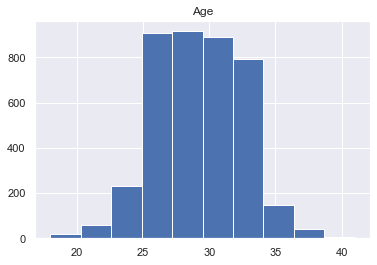

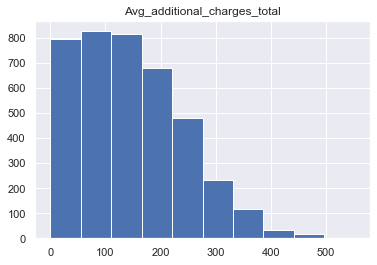

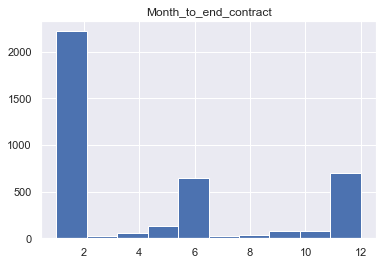

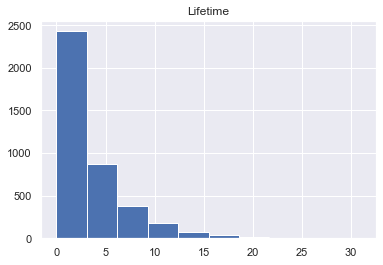

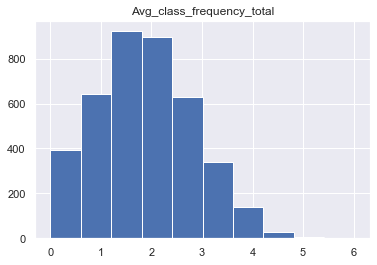

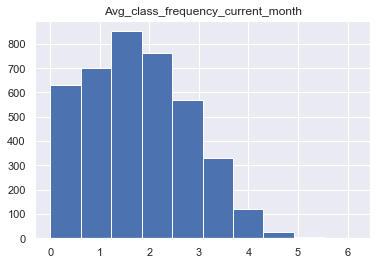

In [6]:
# посмотрим распределение не булевых величин на гистограммах
for column in ['Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime', 
               'Avg_class_frequency_total', 'Avg_class_frequency_current_month']:
    df.hist([column])
    

### Вывод

Все данные в числовом формате, пропусков нет.  
Month_to_end_contract можно перевести в int, в остальном типы данных корректны.

<a name="datacleaning"></a>
## 2. Предобработка данных 
#### [Вернуться к оглавлению](#back) 

In [7]:
# переведем названия столбцов к строчному виду 
df.columns = df.columns.str.lower()

### Работа с дубликатами  
<a name="douplicates"></a>

In [8]:
# проверка числа полностью дублирующихся строк
df.duplicated().sum()

0

### Замена типов данных
<a name="datatypes"></a>

In [9]:
# заменим тип данных в столбце month_to_end_contract на int
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int')
df

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5,3,1.630108,1.596237,0


### Вывод
Дубликатов не обнаружено, все столбцы в правильном формате. Данные готовы к анализу.

<a name="analysis"></a>
## 3. Исследовательский анализ данных (EDA)
#### [Вернуться к оглавлению](#back) 

Проведем исследовательский анализ данных (EDA).  
- Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения;
- Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался;
- Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);
- Построим матрицу корреляций и отобразим её.

In [10]:
# Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


#### Общие характеристики клиентов клуба
По таблице выше видим, что: 
- распределение по полу примерно одинаково,
- большинство клиентов спортзала живут неподалеку,
- чуть меньше половины пришли через компании-партнеров клуба,
- подавляющее большинство посетителей оставили свой контактный телефон,
- более половины клиентов заключили контракт на 1 месяц,
- более половины клиентов не посещали групповые тренировки за рассматриваемый период,
- типичный возраст клиента клуба - 29 лет, плюс-минус 3 года, минимальный - 18 лет,
- в основном, клиенты тратят дополнительно от 50 до 242 у.е. в фитнес-центрах,
- большинство клиентов проводят в клубе 0-6 месяцев,
- более половины клиентов посещают зал хотя бы 1 раз в неделю с начала действия их абониментов, в текущем месяце ситуация такая же.

In [11]:
# Узнаем долю оттока
print('Доля оттока: {:.0%}'.format(len(df.loc[df['churn']==1]) / len(df)))

Доля оттока: 27%


In [12]:
# Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался
df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


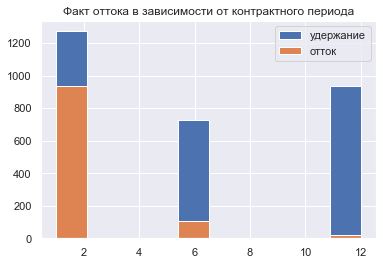

In [13]:
df.groupby('churn')['contract_period'].hist()
plt.title('Факт оттока в зависимости от контрактного периода')
plt.legend(['удержание', 'отток']);

#### Характеристики клиентов клуба с разделением по факту оттока

По таблице выше видим, что:
- распределение по полу примерно одинаково,
- среди тех, кто перестал посещать клуб, большинство живут неподалеку, однако этот показатель ниже, чем в группе оставшихся в клубе,
- большинство ушедших не являются сотрудниками компаний-партнеров (в группе оставшихся более половины - являются),
- среди оставшихся доля тех, кто пришед через акцию, выше,
- подавляющее большинство оставили свой контактный телефон, этот показатель почти одинаков в двух группах,
- в группе оставшихся изначальная средняя длительность контракта выше,
- доля клиентов, которые посещали групповые тренировки вдвое выше среди тех, кто остался,
- средний возраст ушедших клиентов ниже, чем оставшихся,
- в среднем, дополнительные расходы в фитнес-центрах чуть выше среди тех, кто остался,
- среди тех, кто перестал посещать фитнес-центр, срок контракта заканчивался в среднем через 1-2 месяца. Продолжившим посещения клиентам в среднем оставалось еще около 5 месяцев до окончания контракта,
- в среднем уходят клиенты в первый месяц посещения зала,
- те, кто остался, посещают клуб немного чаще, чем ушедшие.

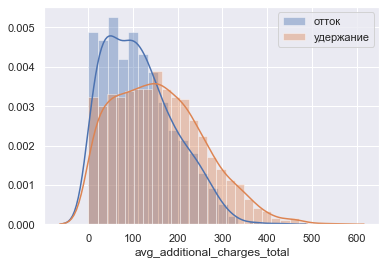

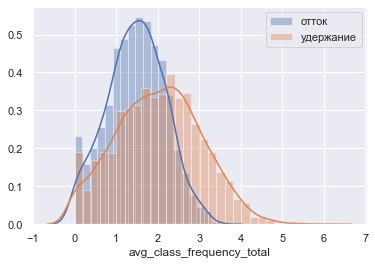

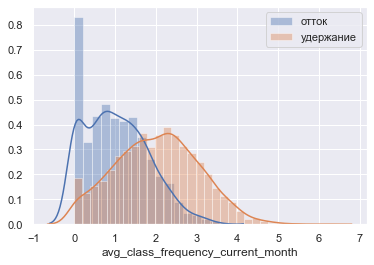

In [14]:
# для непрерывных величин построим дистплоты
displot_col = ['avg_additional_charges_total', 'avg_class_frequency_total', 'avg_class_frequency_current_month']
left = df.loc[df['churn']==1]
stayed = df.loc[df['churn']==0]
for column in displot_col:
    sns.distplot(left[column])
    sns.distplot(stayed[column])
    plt.legend(['отток', 'удержание'])
    plt.show();

Здесь хорошо видно, что большинство из тех, кто ушли, вообще не появлялись в зале за последний месяц.

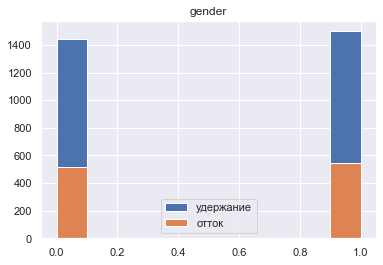

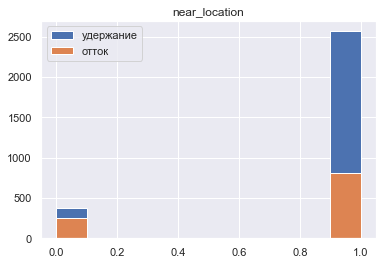

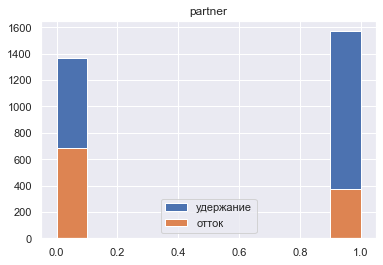

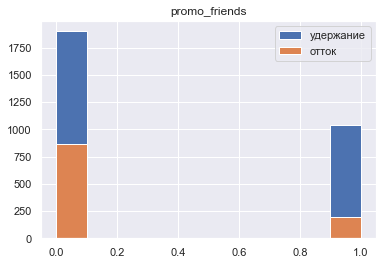

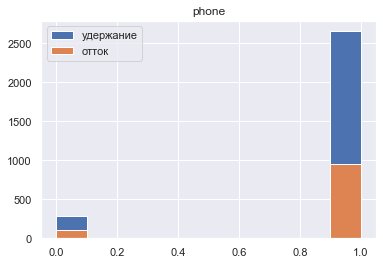

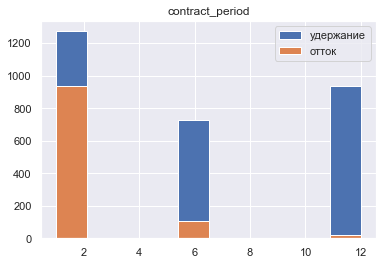

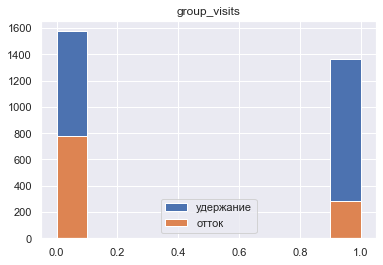

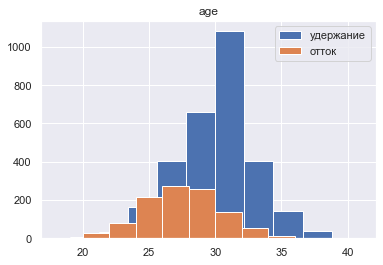

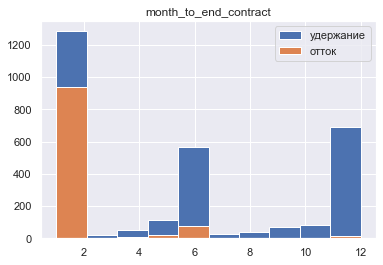

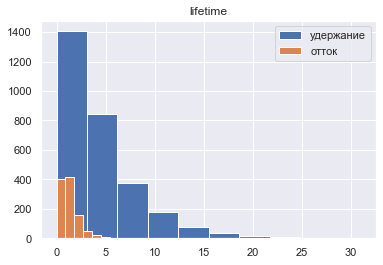

In [15]:
# Построим столбчатые гистограммы и распределения остальных признаков для тех, кто ушёл и тех, кто остался

hist_col = ['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age', 'month_to_end_contract', 'lifetime']

for column in hist_col:
    df.groupby('churn')[column].hist()
    plt.legend(['удержание', 'отток'])
    plt.title(column)
    plt.show()

## Комментарий наставника
<span style="color:green">Хорошо.</span>

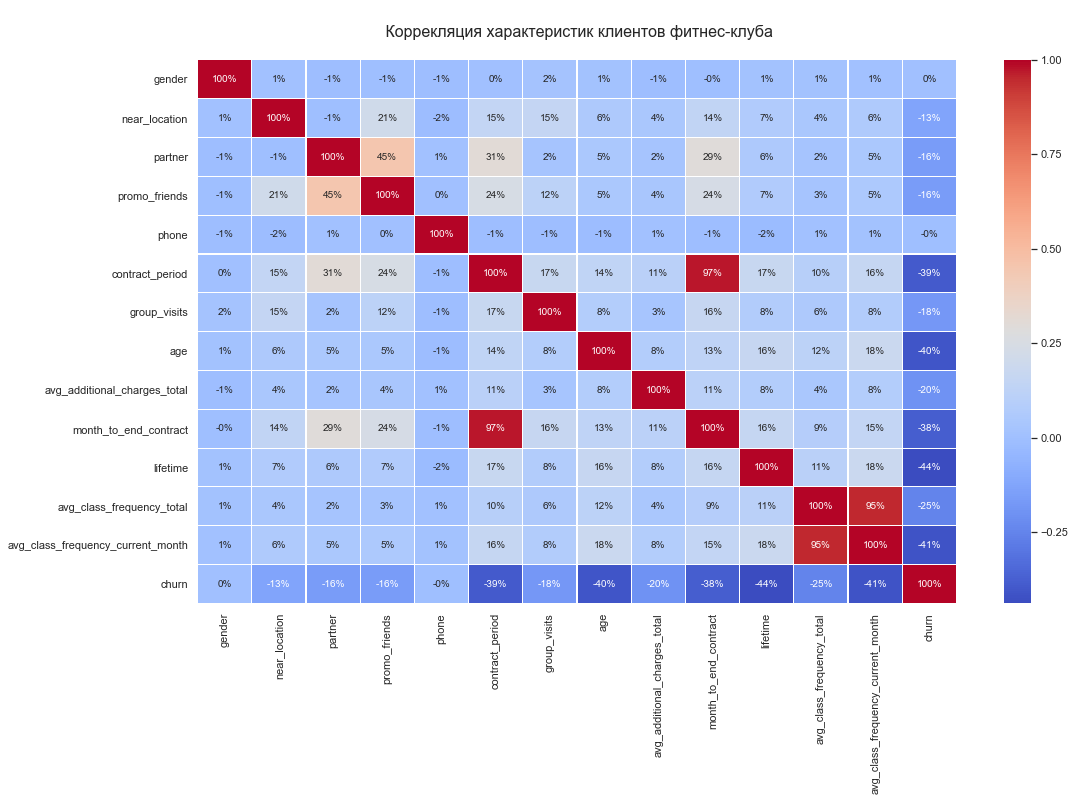

In [16]:
# Построим матрицу корреляций и отобразим её.
fig, ax = plt.subplots(figsize=(17,10))
sns.heatmap(df.corr(), annot=True, fmt='.0%', cmap = 'coolwarm', linewidths=0.1)
ax.set_ylim(14,0)
ax.set_title('\n Коррекляция характеристик клиентов фитнес-клуба\n', fontsize=16);

По матрице корреляций видим, что существует сильная корреляция 
- между сроком до окончания контракта и контрактным периодом
- и между средней частотой посещений в неделю за все время с начала действия абонемента и за предыдущий месяц.  

Это провоцированно тем, что большинство клиентов заключают контракт на 1 месяц, поэтому есть сомнения, что эти факторы - мультиколлениарны.  

Явных зависимостей факта оттока от одного конкретного признака не обнаружено.

### Вывод

Можем предположить, что факторами, увеличивающими вероятность оттока, являются следующие характеристики:  
- удаленность клуба от жилья,
- работодатель не является партнерской компанией клуба,
- клиент пришел не через акцию "приведи друга",
- короткий контрактный период,
- не посещение групповых классов,
- возраст до 30 лет,
- малый срок, оставшийся до конца контракта,
- первый месяц посещений,
- редкие походы в фитнес-центр (менее 2 раз в неделю).

Явных зависимостей факта оттока от одного конкретного признака не обнаружено.

<a name='predictions'></a>
## 4. Модель прогнозирования оттока пользователей
#### [Вернуться к оглавлению](#back) 

**Построим модель прогнозирования оттока пользователей**  
Построим модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце.   
Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Выясним, какая модель показала себя лучше на основании метрик.

In [17]:
# Разобьем данные на обучающую и валидационную выборку.

# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(columns = ['churn'])
y = df['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) #обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

Обучим модель на train-выборке двумя способами:  
- логистической регрессией
- случайным лесом 

In [18]:
# для логистической регрессии подберем циклом параметр random_state 
r_states = [int(x) for x in np.linspace(start = 1, stop = 100, num = 100)]

accuracy_results = []
precision_results = []
recall_results = []
roc_auc_result = []
f1_scors = []

for state in r_states:
    lr = LogisticRegression(random_state=state) # зададим алгоритм для модели логистической регрессии
    lr.fit(X_train_st, y_train)  # обучим модель
    y_pred = lr.predict(X_test_st) 
    # воспользуемся уже обученной моделью, чтобы сделать прогнозы
    y_prob = lr.predict_proba(X_test_st)[:,1]
    
    ac = accuracy_score(y_test, y_pred)
    accuracy_results.append(ac)
    
    pr = precision_score(y_test, y_pred)
    precision_results.append(pr)
    
    rc = recall_score(y_test, y_pred)
    recall_results.append(rc)
    
    f1 = f1_score(y_test, y_pred)
    f1_scors.append(f1)
    
    roc = roc_auc_score(y_test, y_prob)
    roc_auc_result.append(roc)
    
d = {'model': 'Logistic Regression',
    'random_state': r_states,
     'accuracy': accuracy_results,
     'precision': precision_results,
     'recall': recall_results,
    'roc_auc': roc_auc_result,
    'f1': f1_scors}

lr_result = pd.DataFrame(data=d)
lr_result.sort_values(by = 'accuracy', ascending = False).head(1)

,model,random_state,accuracy,precision,recall,roc_auc,f1
0,Logistic Regression,1,0.9225,0.854167,0.828283,0.970402,0.841026


In [19]:
# для RandomForestClassifier подберем циклом гипперпараметр n_estimators 
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100, num = 100)]
accuracy_results = []
precision_results = []
recall_results = []
roc_auc_result = []
f1_scors = []

for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, random_state=0)
    rf.fit(X_train_st, y_train)
    y_pred = rf.predict(X_test_st)
    y_prob = rf.predict_proba(X_test_st)[:,1]
    
    ac = accuracy_score(y_test, y_pred)
    accuracy_results.append(ac)
    
    pr = precision_score(y_test, y_pred)
    precision_results.append(pr)
    
    rc = recall_score(y_test, y_pred)
    recall_results.append(rc)
    
    f1 = f1_score(y_test, y_pred)
    f1_scors.append(f1)
    
    roc = roc_auc_score(y_test, y_prob)
    roc_auc_result.append(roc)
    
# выберем, при какаом значении n_estimators значение accuracy максимально
d = {'n_estimators': n_estimators, 
     'accuracy': accuracy_results,
     'precision': precision_results,
     'recall': recall_results,
    'roc_auc': roc_auc_result,
    'f1': f1_scors}

pf = pd.DataFrame(data=d)
pf.sort_values(by = 'accuracy', ascending = False).head(3)

,n_estimators,accuracy,precision,recall,roc_auc,f1
38,39,0.92125,0.842640,0.838384,0.965460,0.840506
42,43,0.92125,0.839196,0.843434,0.965351,0.841310
44,45,0.92125,0.839196,0.843434,0.965683,0.841310


In [20]:
# Подберем параметр max_depth при котором значение accuracy максимально
depth = [int(x) for x in np.linspace(start = 1, stop = 100, num = 100)]

accuracy_results = []
precision_results = []
recall_results = []
roc_auc_result = []
f1_scors = []

for d in depth:
    rf = RandomForestClassifier(n_estimators=39, max_depth = d)
    rf.fit(X_train_st, y_train)
    y_pred = rf.predict(X_test_st)
    y_prob = rf.predict_proba(X_test_st)[:,1]
    
    ac = accuracy_score(y_test, y_pred)
    accuracy_results.append(ac)
    
    pr = precision_score(y_test, y_pred)
    precision_results.append(pr)
    
    rc = recall_score(y_test, y_pred)
    recall_results.append(rc)
    
    f1 = f1_score(y_test, y_pred)
    f1_scors.append(f1)
    
    roc = roc_auc_score(y_test, y_prob)
    roc_auc_result.append(roc)
    
d = {'n_estimators': 39,
     'max_depth': depth,
     'accuracy': accuracy_results,
     'precision': precision_results,
     'recall': recall_results,
    'roc_auc': roc_auc_result,
    'f1': f1_scors}

pf = pd.DataFrame(data=d)
pf.sort_values(by = 'accuracy', ascending = False).head(3)

,n_estimators,max_depth,accuracy,precision,recall,roc_auc,f1
94,39,95,0.92375,0.844221,0.848485,0.969265,0.846348
93,39,94,0.92250,0.843434,0.843434,0.968850,0.843434
55,39,56,0.92250,0.843434,0.843434,0.966819,0.843434


In [32]:
# Теперь подберем random_state 

r_states = [int(x) for x in np.linspace(start = 1, stop = 1000, num = 1000)]

accuracy_results = []
precision_results = []
recall_results = []
roc_auc_result = []
f1_scors = []

for state in r_states:
    rf = RandomForestClassifier(n_estimators=39, max_depth=95, random_state=state)
    rf.fit(X_train_st, y_train)
    y_pred = rf.predict(X_test_st)
    y_prob = rf.predict_proba(X_test_st)[:,1]
    
    ac = accuracy_score(y_test, y_pred)
    accuracy_results.append(ac)
    
    pr = precision_score(y_test, y_pred)
    precision_results.append(pr)
    
    rc = recall_score(y_test, y_pred)
    recall_results.append(rc)
    
    f1 = f1_score(y_test, y_pred)
    f1_scors.append(f1)
    
    roc = roc_auc_score(y_test, y_prob)
    roc_auc_result.append(roc)
    
d = {'model': 'Random Forest',
    'n_estimators': 39,
     'max_depth': 95,
    'random_state': r_states,
     'accuracy': accuracy_results,
     'precision': precision_results,
     'recall': recall_results,
    'roc_auc': roc_auc_result,
    'f1': f1_scors}

rf_result = pd.DataFrame(data=d)
rf_result.sort_values(by = 'accuracy', ascending = False).head(1)

,model,n_estimators,max_depth,random_state,accuracy,precision,recall,roc_auc,f1
589,Random Forest,39,95,590,0.92875,0.865285,0.843434,0.967436,0.85422


In [22]:
# объединим таблицы с метриками обеих моделей и отсортируем по убыванию accuracy
rf_result.merge(lr_result, how='outer').sort_values(by = 'accuracy', ascending = False).head(1)

,model,n_estimators,max_depth,random_state,accuracy,precision,recall,roc_auc,f1
589,Random Forest,39.0,90.0,590,0.92875,0.865285,0.843434,0.967436,0.85422


Итак, модель случайного леса с параметрами n_estimators=39, max_depth=95 и random_state=590 дала наилучший показатель accuracy - 92.875%.

In [23]:
# Теперь посмотрим на веса признаков в окончательной модели

# обучаем финальную модель
final_model = RandomForestClassifier(n_estimators=39, max_depth=90, random_state=state)
final_model.fit(X_train_st, y_train)
y_pred = final_model.predict(X_test_st)
importances = final_model.feature_importances_

# создаем дф с признаками и их весами, сортируем по убыванию
features_weight = pd.DataFrame(importances, X.columns.tolist(), columns=['weight'])
features_weight.sort_values(by='weight', ascending=False)

,weight
lifetime,0.299001
avg_class_frequency_current_month,0.170472
avg_class_frequency_total,0.130643
age,0.112997
avg_additional_charges_total,0.084307
month_to_end_contract,0.070197
contract_period,0.064781
group_visits,0.016781
gender,0.012233
partner,0.011804


### Вывод 
Модель случайного леса с параметрами n_estimators=39, max_depth=95 и random_state=590 дала наилучший показатель accuracy - 92.875%.
В этой модели самыми весомыми признаками оказались срок членства в фитнес-клубе, частота посещений и возраст. Стоит уделить особое внимание этим характеристикам клиентов при составлении стартегии снижения оттока.

<a name='clusters'></a>
## 5. Кластеризация пользователей
#### [Вернуться к оглавлению](#back) 

**Проведем кластеризацию объектов (пользователей)**
- Отбросив churn, стандартизируем данные.
- Построим матрицу расстояний функцией на стандартизованной матрице признаков и нарисуем дендрограмму. На основании полученного графика предположим, какое количество кластеров можно выделить.
- Обучим модель кластеризации на основании алгоритма K-Means с числом кластеров n=5 согласно ТЗ и спрогнозируем кластеры клиентов. 
- Рассмотрим средние значения признаков для кластеров.
- Построим распределения признаков для кластеров. 
- Для каждого полученного кластера посчитаем долю оттока. Выясним, какие кластеры склонны к оттоку, а какие — надёжны.

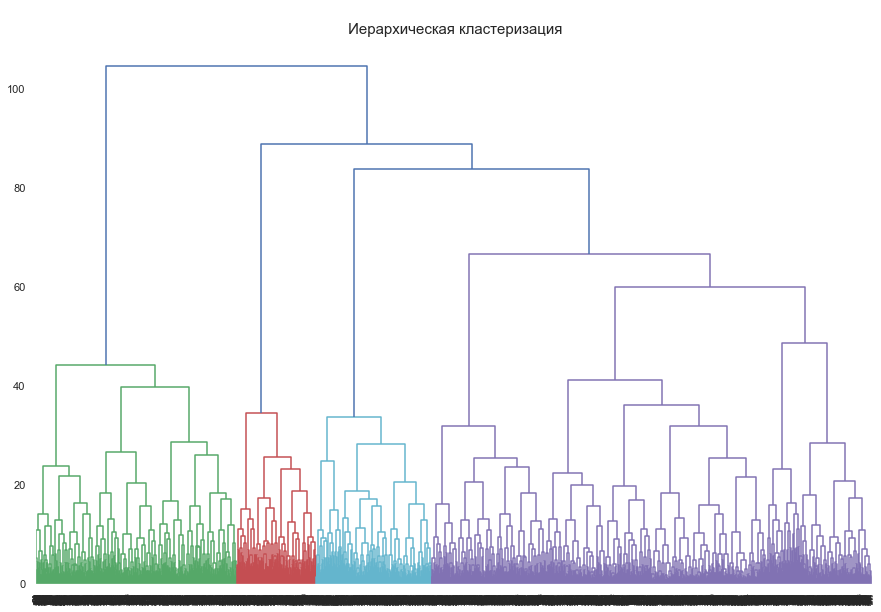

In [24]:
x_sc = scaler.fit_transform(X) # стандантизируем матрицу признаков
linked = linkage(x_sc, method='ward') # строим матрицу расстояний 

# построим дендрограмму кластеров
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('\n Иерархическая кластеризация', fontsize=15)
plt.show();

По графику кластера 4, но мы разобьем выборку на 5 согласно ТЗ.

In [25]:
# Обучим модель кластеризации на основании алгоритма K-Means

# задаём модель k_means с числом кластеров 5 по ТЗ
km = KMeans(n_clusters = 5, random_state=0)
# прогнозируем кластеры для наблюдений 
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
df.groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.706969,9.950544,4.738872,1.983305,1.976225,0.027695
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724258,2.455197,4.896057,2.851531,2.849473,0.068100


### Построим распределения признаков для кластеров


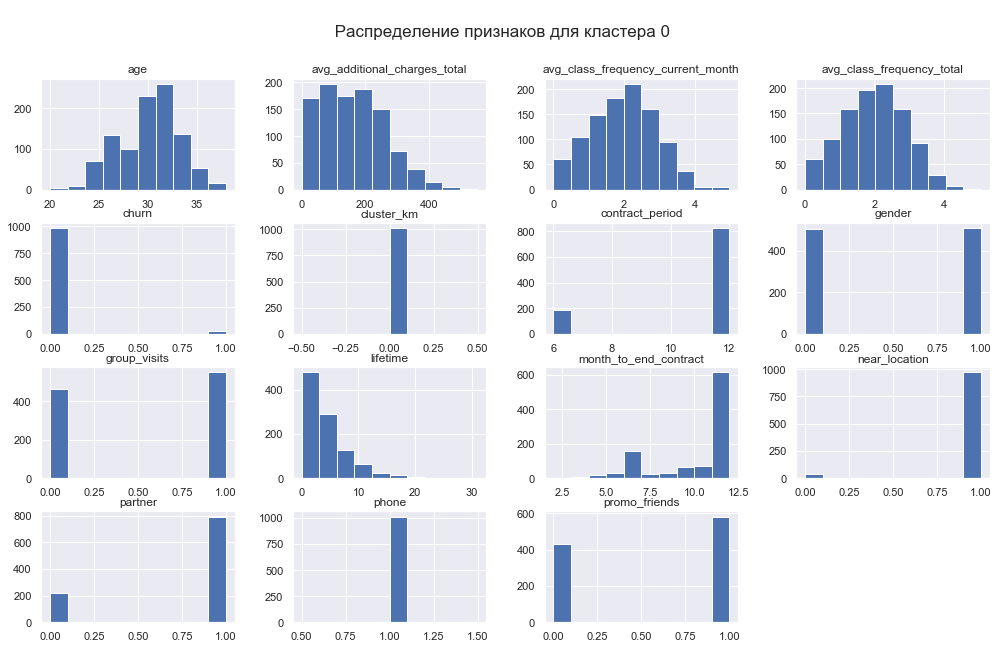

In [26]:
df.loc[df['cluster_km']==0].hist(figsize=(17,10))
plt.suptitle('\n Распределение признаков для кластера 0', fontsize=17);

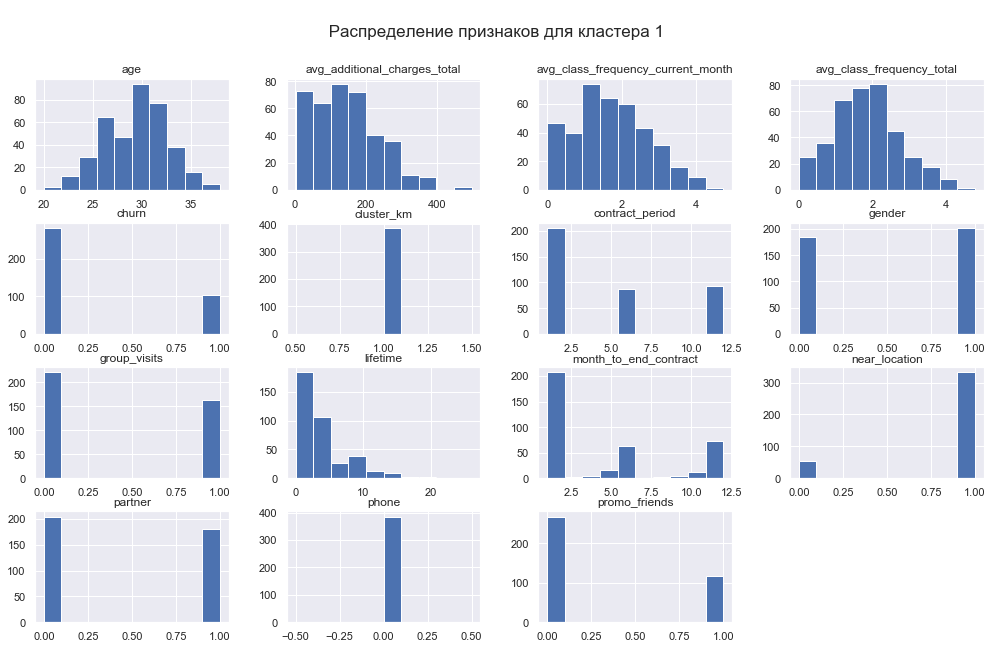

In [27]:
df.loc[df['cluster_km']==1].hist(figsize=(17,10))
plt.suptitle('\n Распределение признаков для кластера 1', fontsize=17);

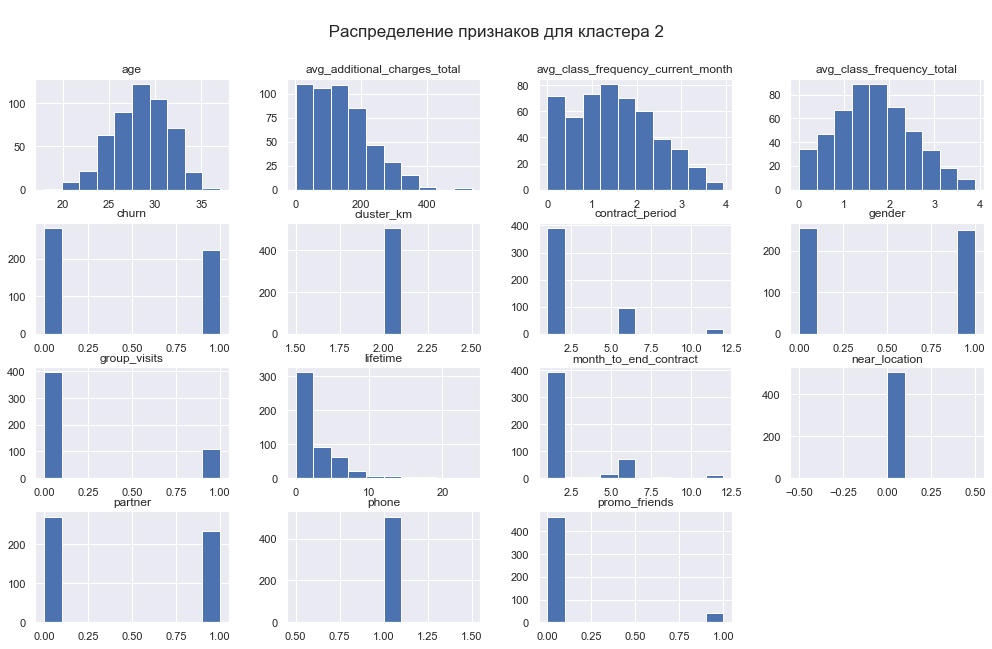

In [28]:
df.loc[df['cluster_km']==2].hist(figsize=(17,10))
plt.suptitle('\n Распределение признаков для кластера 2', fontsize=17);

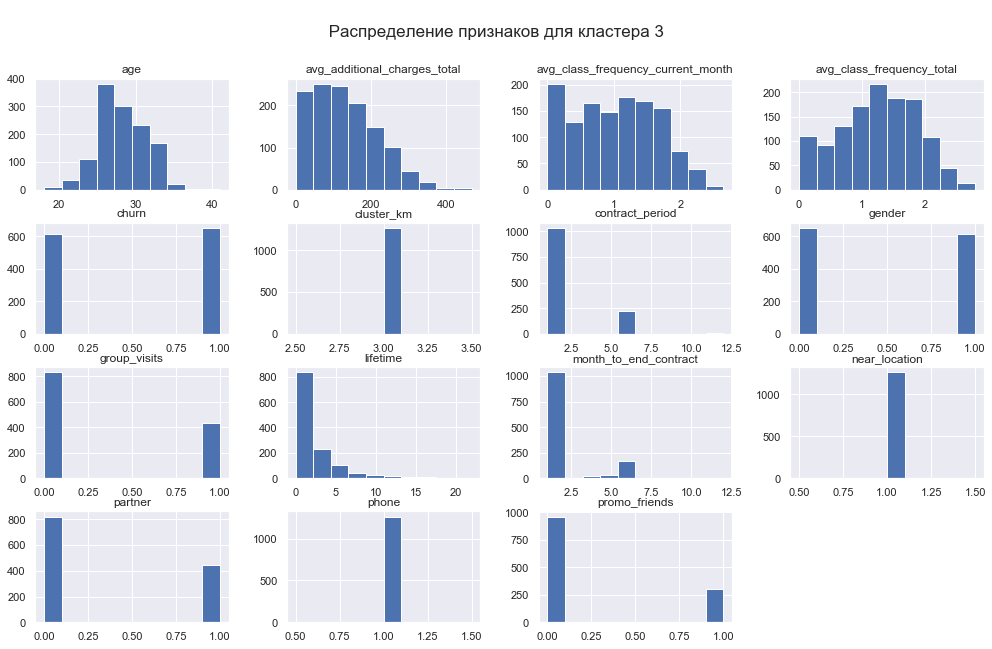

In [29]:
df.loc[df['cluster_km']==3].hist(figsize=(17,10))
plt.suptitle('\n Распределение признаков для кластера 3', fontsize=17);

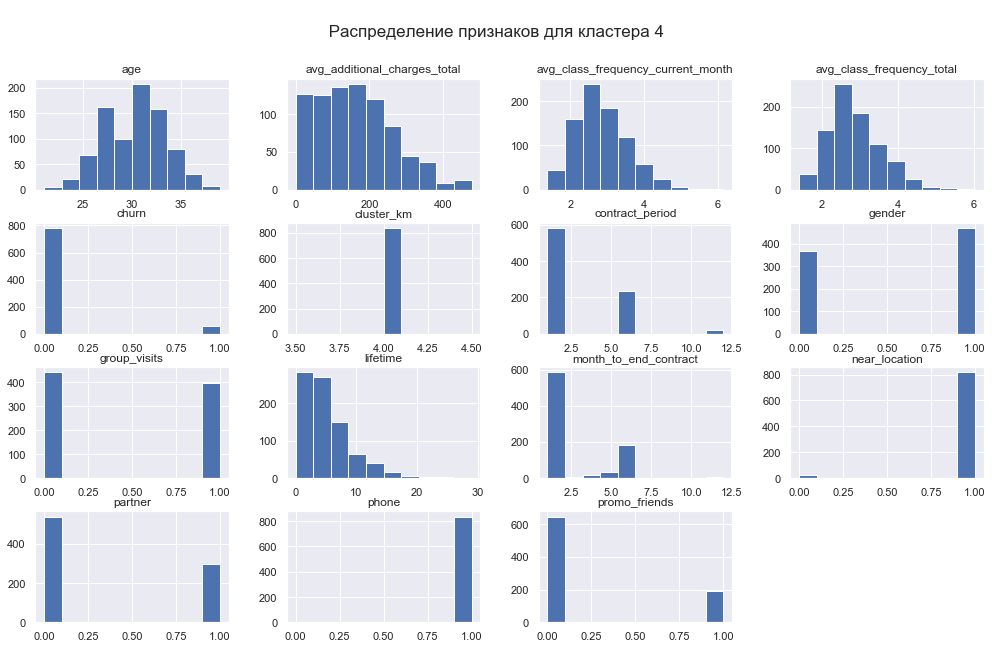

In [30]:
df.loc[df['cluster_km']==4].hist(figsize=(17,10))
plt.suptitle('\n Распределение признаков для кластера 4', fontsize=17);

In [33]:
churn_by_cluster = df.groupby('cluster_km')['churn'].mean().reset_index()
churn_by_cluster['churn'] = churn_by_cluster['churn'].map('{:,.0%}'.format)
churn_by_cluster

,cluster_km,churn
0,0,3%
1,1,27%
2,2,44%
3,3,51%
4,4,7%


Характеристики кластеров:  

**Кластер 0 - вероятность оттока 3%** - для пользователей, собранных в этой группе, заметно выше контрактный период (в среднем 10.8 месяцев), время с момента первого обращения в фитнес-центр в среднем около 5 месяцев (что выше, чем в большинстве других кластеров). Большинство из них являются сотрудниками компаний-партнеров клуба. **Это лояльные клиенты с долгосрочными планами на спорт-зал и финансовыми бонусами от компаний-партнеров клуба. Вероятность их оттока минимальна**. 

**Кластер 1 - вероятность оттока 27%** - здесь собраны все, кто не указал номер телефона при регистрации в клубе. В остальном показатели членов этого кластера усреднены. Вероятность оттока здесть такая же, как и в среднем по всем пользователям. **Скорее всего, факт указания номера телефона не является весомым для фактора оттока.**

**Кластер 2 - вероятность оттока 44%** - здесь все, кто живут далеко от спорт-зала. Из них почти никого, кто пришел по акции "приведи друга". Не смотря на то, что пользователи в среднем довольно регулярно посещали зал, вероятность их оттока довольно высока. **Очевидно, людям больше нравится ходить в спорт-клуб неподалеку от дома и с друзьями.**  

**Кластер 3 - вероятность оттока 51%** - это клиенты, заключившие контракт с клубом на небольшой срок. У них осталось меньше всего месяцев до окончания членства, по сравнению с клиентами из других кластеров. К тому же, многие из них за последний месяц в зале появлялись мало или вообще не появлялись. **Это пришедшие в клуб "попробовать", но так и не ставшие регулярными посетителями спорт-клуба. Вероятность их оттока велика**.  

**Кластер 4 - вероятность оттока 7%** - здесь собраны пользователи, посещающие клуб чаще, чем в остальных группах (в среднем 2-3 раза в неделю). Средний возраст здесь чуть выше, чем в остальных кластерах - 30 лет и время с момента первого обращения в фитнес-центр в среднем около 5 месяцев (что выше, чем во всех других кластерах). **Это регулярные посетители зала, вероятность потерять их мала.** 



### Вывод

Мы разбили пользователей на 5 кластеров по комбинациям характеристик. Проанализировав характеристики пользователей каждого кластера и вероятность их оттока, мы выделили группы, которые с большей вероятностью перестанут посещать спорт-клуб, и с меньшей. 

В группе риска оттока:
- клиенты, заключившие контракт с клубом на небольшой срок. У них осталось меньше всего месяцев до окончания членства, по сравнению с клиентами из друних кластеров. К тому же, многие из них за последний месяц в зале появлялись мало или вообще не появлялись. Это пришедшие в клуб "попробовать", но так и не ставшие регулярными посетителями спорт-клуба;
- те, кто живут далеко от спорт-зала. Из них почти никого, кто пришел по акции "приведи друга". Не смотря на то, что пользователи в среднем довольно регулярно посещали зал, вероятность их оттока довольно высока. Очевидно, людям больше нравится ходить в спорт-клуб неподалеку от дома и с друзьями.  

Среди менее вероятных к уходу клиентов:
- пользователи, посещающие клуб чаще, чем в остальных группах (в среднем 2-3 раза в неделю).Средний возраст здесь чуть выше, чем в остальных кластерах - 30 лет и время с момента первого обращения в фитнес-центр в среднем около 5 месяцев (что выше, чем в большинстве других кластеров);
- клиенты с заметно большим контрактным периодом (в среднем 10.8 месяцев), временем с момента первого обращения в фитнес-центр в среднем около 5 месяцев (выше, чем во всех других кластерах). Большинство из них являются сотрудниками компаний-партнеров клуба. Это лояльные клиенты с долгосрочными планами на спорт-зал и финансовыми бонусами от компаний-партнеров клуба.  


Также мы определили, что факт указания номера телефона не является весомым для фактора оттока.

<a name='conclusion'></a>
## Вывод  
#### [Вернуться к оглавлению](#back) 

Мы рассмотрели *общие характеристики членов клуба*:

- распределение по полу примерно одинаково,
- большинство клиентов спортзала живут неподалеку,
- чуть меньше половины пришли через компании-партнеров клуба,
- подавляющее большинство посетителей оставили свой контактный телефон,
- более половины клиентов заключили контракт на 1 месяц,
- более половины клиентов не посещали групповые тренировки за рассматриваемый период,
- типичный возраст клиента клуба - 29 лет, плюс-минус 3 года, минимальный - 18 лет,
- в основном, клиенты тратят дополнительно от 50 до 242 у.е. в фитнес-центрах,
- большинство клиентов проводят в клубе 0-6 месяцев,
- более половины клиентов посещают зал хотя бы 1 раз в неделю с начала действия их абониментов, в текущем месяце ситуация такая же.

**Доля оттока среди них - 27%.**
Наша задача - снизить этот показатель. Для этого постараемся понять, пользователи с каими характеристиками имеют большую вероятность к уходу, и разработать стратегию удержания, направленную на клиентов со схожими характеристиками.

*Сравнив черты ушедших и оставшихся пользователей*, мы выяснили, что:
- распределение по полу примерно одинаково,
- среди тех, кто перестал посещать клуб, большинство живут неподалеку, однако этот показатель ниже, чем в группе оставшихся в клубе,
- большинство ушедших не являются сотрудниками компаний-партнеров (в группе оставшихся более половины - являются),
- среди оставшихся доля тех, кто пришед через акцию, выше,
- подавляющее большинство оставили свой контактный телефон, этот показатель почти одинаков в двух группах,
- в группе оставшихся изначальная средняя длительность контракта выше,
- доля клиентов, которые посещали групповые тренировки вдвое выше среди тех, кто остался,
- средний возраст ушедших клиентов ниже, чем оставшихся,
- в среднем, дополнительные расходы в фитнес-центрах чуть выше среди тех, кто остался,
- среди тех, кто перестал посещать фитнес-центр, срок контракта заканчивался в среднем через 1-2 месяца. Продолжившим посещения клиентам в среднем оставалось еще около 5 месяцев до окончания контракта,
- в среднем уходят клиенты в первый месяц посещения зала,
- те, кто остался, посещают клуб немного чаще, чем ушедшие.

Исходя из этого, можем предположить, что факторами, увеличивающими вероятность оттока, являются следующие характеристики:  
- удаленность клуба от жилья,
- работодатель не является партнерской компанией клуба,
- клиент пришел не через акцию "приведи друга",
- короткий контрактный период,
- не посещение групповых классов,
- возраст до 30 лет,
- малый срок, оставшийся до конца контракта,
- первый месяц посещений,
- редкие походы в фитнес-центр (менее 2 раз в неделю).

Явных зависимостей факта оттока от одного конкретного признака из рассматриваемых не обнаружено.
    
Мы обучили модель бинарной классификации для предсказания факта оттока двумя способами: логистической регрессией и случайным лесом. 
**Модель случайного леса с параметрами n_estimators=39, max_depth=95 и random_state=590 дала наилучший показатель accuracy - 92.875%**. В этой модели самыми весомыми признаками оказались срок членства в фитнес-клубе, частота посещений и возраст. Стоит уделить особое внимание этим характеристикам клиентов при составлении стартегии снижения оттока.  

Также мы разбили выборку на **5 кластеров** и исследовали их характеристики и соответствующую вероятность оттока.

Характеристики кластеров:

**Кластер 0 - вероятность оттока 3%** - для пользователей, собранных в этой группе, заметно выше контрактный период (в среднем 10.8 месяцев), время с момента первого обращения в фитнес-центр в среднем около 5 месяцев (что выше, чем в большинстве других кластеров). Большинство из них являются сотрудниками компаний-партнеров клуба. **Это лояльные клиенты с долгосрочными планами на спорт-зал и финансовыми бонусами от компаний-партнеров клуба. Вероятность их оттока минимальна**. 

**Кластер 1 - вероятность оттока 27%** - здесь собраны все, кто не указал номер телефона при регистрации в клубе. В остальном показатели членов этого кластера усреднены. Вероятность оттока здесть такая же, как и в среднем по всем пользователям. **Скорее всего, факт указания номера телефона не является весомым для фактора оттока.**

**Кластер 2 - вероятность оттока 44%** - здесь все, кто живут далеко от спорт-зала. Из них почти никого, кто пришел по акции "приведи друга". Не смотря на то, что пользователи в среднем довольно регулярно посещали зал, вероятность их оттока довольно высока. **Очевидно, людям больше нравится ходить в спорт-клуб неподалеку от дома и с друзьями.**  

**Кластер 3 - вероятность оттока 51%** - это клиенты, заключившие контракт с клубом на небольшой срок. У них осталось меньше всего месяцев до окончания членства, по сравнению с клиентами из других кластеров. К тому же, многие из них за последний месяц в зале появлялись мало или вообще не появлялись. **Это пришедшие в клуб "попробовать", но так и не ставшие регулярными посетителями спорт-клуба. Вероятность их оттока велика**.  

**Кластер 4 - вероятность оттока 7%** - здесь собраны пользователи, посещающие клуб чаще, чем в остальных группах (в среднем 2-3 раза в неделю). Средний возраст здесь чуть выше, чем в остальных кластерах - 30 лет и время с момента первого обращения в фитнес-центр в среднем около 5 месяцев (что выше, чем во всех других кластерах). **Это регулярные посетители зала, вероятность потерять их мала.** 

Таким образом, клиенты с характеристиками, схожими с характеристиками кластеров 2 и 3 с большей вероятностью перестанут посещать спорт-клуб. Для этих пользователей можно разработать специальные предложения, а также выгодные условия для заключения контракта сразу на долгий срок (например, ограниченное по времени предложение с более привлекательной ценой для годового абонимента). 
Также стоит сосредоточиться на привлечении пользователей, живущих неподалеку. Например, сосредоточить гео-таргетинг рекламы на зоне возле спорт-клуба.